In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision import transforms

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
BATCH_SIZE = 20
VALID_SPLIT = 0.2
SEED = 42

LEARNING_RATE = 0.01
N_EPOCHS = 20



#### Load data

In [4]:
transf = transforms.ToTensor()
train_folder = datasets.ImageFolder(root="../dataset/train/", 
                                    transform=transf)
test_folder = datasets.ImageFolder(root="../dataset/test/", 
                                   transform=transf)
train_folder

Dataset ImageFolder
    Number of datapoints: 10000
    Root Location: ../dataset/train/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
n_train = len(train_folder)
indices = list(range(n_train))
np.random.seed(SEED)
np.random.shuffle(indices)
split = int(np.floor(VALID_SPLIT * n_train))
train_indices, valid_indices = indices[split:], indices[:split]

In [6]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [7]:
train_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_folder, 
                                           batch_size=BATCH_SIZE, 
                                           sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_folder, 
                                          batch_size=BATCH_SIZE)

#### Define custom CNN architecture

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 96x96x3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 48x48x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 24x24x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # 12x12x64
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12*12*64, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 12*12*64)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


#### Train the model

In [17]:
# specify loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

valid_loss_min = np.Inf  # to track change in validation loss

for epoch in range(1, N_EPOCHS+1):

    print(f"epoch {epoch}")

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    
    for i, (data, target) in enumerate(train_loader):
        #print(f"batch {i+1}/{len(train_loader)}")

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_indices)
    valid_loss = valid_loss/len(valid_indices)

    # print training/validation statistics 
    print(f"Epoch: {epoch}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {valid_loss:.6f}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), "mobi_cnn.pt")
        valid_loss_min = valid_loss

epoch 1
Epoch: 1	Training Loss: 1.106827	Validation Loss: 1.200502
Validation loss decreased (inf --> 1.200502).  Saving model ...
epoch 2
Epoch: 2	Training Loss: 1.070159	Validation Loss: 1.202125
epoch 3
Epoch: 3	Training Loss: 1.018853	Validation Loss: 1.184996
Validation loss decreased (1.200502 --> 1.184996).  Saving model ...
epoch 4
Epoch: 4	Training Loss: 0.973231	Validation Loss: 1.198396
epoch 5
Epoch: 5	Training Loss: 0.920441	Validation Loss: 1.167594
Validation loss decreased (1.184996 --> 1.167594).  Saving model ...
epoch 6
Epoch: 6	Training Loss: 0.871511	Validation Loss: 1.170729
epoch 7
Epoch: 7	Training Loss: 0.808068	Validation Loss: 1.169195
epoch 8
Epoch: 8	Training Loss: 0.760400	Validation Loss: 1.141346
Validation loss decreased (1.167594 --> 1.141346).  Saving model ...
epoch 9
Epoch: 9	Training Loss: 0.691607	Validation Loss: 1.194598
epoch 10
Epoch: 10	Training Loss: 0.646281	Validation Loss: 1.149213
epoch 11
Epoch: 11	Training Loss: 0.567605	Validation Los

Model starts to overfit quite fast:
* after epoch 8 validation loss even increases, 
* while training loss decrease very fast.

_Note that the model used for testing is the one saved after Epoch 8._

#### Test the model

In [19]:
# load best model
model.load_state_dict(torch.load("mobi_cnn.pt"))

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # evaluation mode (to disable Dropout layers for example)

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}")

classes = test_folder.classes

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.142562
Test Accuracy of airplane: 73% (219/300)
Test Accuracy of  bird: 50% (152/300)
Test Accuracy of   car: 71% (213/300)
Test Accuracy of   cat: 41% (125/300)
Test Accuracy of  deer: 58% (176/300)
Test Accuracy of   dog: 35% (106/300)
Test Accuracy of horse: 73% (219/300)
Test Accuracy of monkey: 51% (155/300)
Test Accuracy of  ship: 69% (208/300)
Test Accuracy of truck: 68% (205/300)

Test Accuracy (Overall): 59% (1778/3000)


#### Visualize Sample Test Results

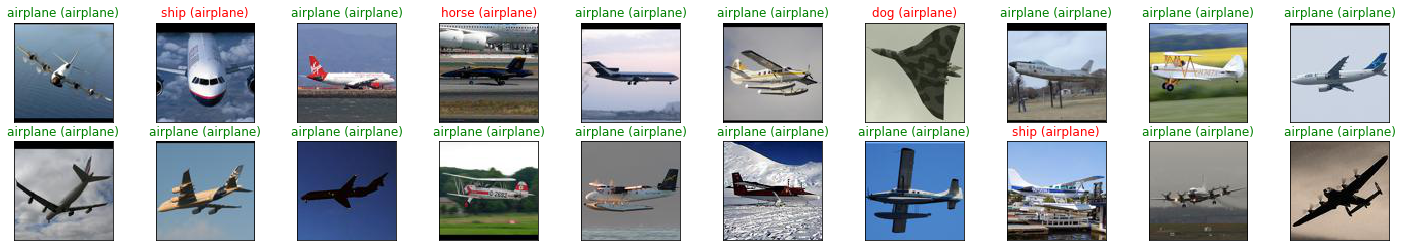

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in range(BATCH_SIZE):
    ax = fig.add_subplot(2, int(BATCH_SIZE/2), idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0))  # CHW -> HWC
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

#### CNN conclusion

These results already looks way better (59% total accuracy) than a previously trained MLP (37%).

This is explained by the fact that a CNN, unlike a simple MLP, is capturing spatial information from locally-connected regions.
It is able to extract features that characterize our classes.

We could do more tuning of this CNN, trying a lot of different architectures. But, since this CNN is also kind of a baseline-CNN, with really simple architecture, we won't spend more time on it, but just analyze its accuracy and then pass to **transfer learning** approach, making use of *unlabelled* data to pre-train feature extraction layer to our dataset.
